[*********************100%***********************]  1 of 1 completed
c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/100, Loss: 0.656478
Epoch 2/100, Loss: 0.080197
Epoch 3/100, Loss: 0.072098
Epoch 4/100, Loss: 0.062358
Epoch 5/100, Loss: 0.026648
Epoch 6/100, Loss: 0.015766
Epoch 7/100, Loss: 0.014622
Epoch 8/100, Loss: 0.012946
Epoch 9/100, Loss: 0.012571
Epoch 10/100, Loss: 0.012023
Epoch 11/100, Loss: 0.010096
Epoch 12/100, Loss: 0.009306
Epoch 13/100, Loss: 0.008525
Epoch 14/100, Loss: 0.009061
Epoch 15/100, Loss: 0.008004
Epoch 16/100, Loss: 0.009293
Epoch 17/100, Loss: 0.008183
Epoch 18/100, Loss: 0.007281
Epoch 19/100, Loss: 0.008239
Epoch 20/100, Loss: 0.007980
Epoch 21/100, Loss: 0.008047
Epoch 22/100, Loss: 0.007977
Epoch 23/100, Loss: 0.007047
Epoch 24/100, Loss: 0.009407
Epoch 25/100, Loss: 0.007976
Epoch 26/100, Loss: 0.006690
Epoch 27/100, Loss: 0.007058
Epoch 28/100, Loss: 0.007008
Epoch 29/100, Loss: 0.006985
Epoch 30/100, Loss: 0.006814
Epoch 31/100, Loss: 0.006815
Epoch 32/100, Loss: 0.006713
Epoch 33/100, Loss: 0.006693
Epoch 34/100, Loss: 0.007046
Epoch 35/100, Loss: 0.0

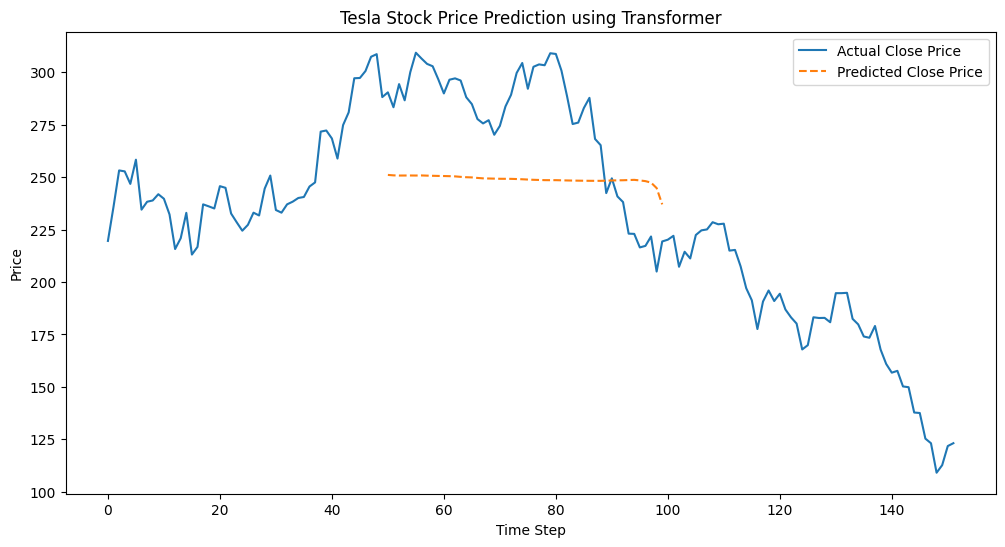

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 로딩 및 전처리
def load_and_preprocess_data(ticker, start_date, end_date, feature='Close', split_ratio=0.8):
    """
    yfinance를 사용하여 주가 데이터를 다운로드하고, 지정한 feature를 선택 후 정규화 및 학습/테스트 분할을 수행합니다.
    """
    df = yf.download(ticker, start=start_date, end=end_date)
    data = df[[feature]].values  # shape: [num_samples, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    split_idx = int(len(data_scaled) * split_ratio)
    train_data = data_scaled[:split_idx]
    test_data = data_scaled[split_idx:]
    return train_data, test_data, scaler

# 2. Dataset 및 DataLoader 구성
class TimeSeriesDataset(Dataset): # 이 클래스는 PyTorch의 Dataset을 상속받아 시계열 데이터를 처리하기 위한 사용자 정의 데이터셋
    def __init__(self, data, seq_length): # 입력 데이터와 시퀀스 길이를 받아 초기화
        self.data = torch.tensor(data, dtype=torch.float32)
        self.seq_length = seq_length

    def __len__(self): # 데이터셋의 전체 길이(샘플의 개수)를 반환
        return len(self.data) - self.seq_length # 시퀀스의 마지막 인덱스에서 seq_length만큼의 데이터를 뽑을 수 없기 때문에 전체 데이터에서 제외

    def __getitem__(self, idx): # 주어진 인덱스 idx에 해당하는 데이터 샘플을 반환
        # src: seq_length 시퀀스, tgt: 그 다음 시점의 값
        # src (입력 시퀀스): self.data에서 idx부터 idx + seq_length까지의 연속된 데이터를 슬라이스하여 반환. 이 데이터는 모델의 입력으로 사용
        # tgt (타겟 값): self.data에서 idx + seq_length 위치의 데이터
        # 반환 값은 (src, tgt)로, 각각 [seq_length, input_dim]과 [input_dim]의 형태
        src = self.data[idx:idx + self.seq_length]  # [seq_length, input_dim]
        tgt = self.data[idx + self.seq_length]       # [input_dim]
        return src, tgt

    # __len__(), __getitem__() 는 실제로는 DataLoader가 내부적으로 이 함수들을 사용하여 데이터를 불러오기 때문에 이 함수들을 구현해야 함

def create_dataloader(data, seq_length, batch_size, shuffle=True):
    #이 함수는 위에서 정의한 TimeSeriesDataset을 이용하여 PyTorch의 DataLoader 객체를 생성 
    dataset = TimeSeriesDataset(data, seq_length)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

# 3. Transformer 기반 시계열 예측 모델 정의
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout
        )
        self.fc_out = nn.Linear(d_model, input_dim)

    def forward(self, src, tgt):
        # src: [S, N, input_dim], tgt: [T, N, input_dim]
        src_emb = self.embedding(src)   # [S, N, d_model]
        tgt_emb = self.embedding(tgt)     # [T, N, d_model]
        output = self.transformer(src_emb, tgt_emb)  # [T, N, d_model]
        return self.fc_out(output)      # [T, N, input_dim]

# 4. 모델 학습 함수
def train_model(model, train_loader, device, epochs, learning_rate=0.001):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        epoch_loss = 0
        for src, tgt in train_loader:
            src = src.to(device)   # [batch, seq_length, input_dim]
            tgt = tgt.to(device)   # [batch, input_dim]
            
            # Transformer 입력은 [sequence_length, batch, feature]
            src = src.transpose(0, 1)  # [seq_length, batch, input_dim]
            # 디코더 입력: 단일 스텝 예측을 위해 0 벡터 사용 (shape: [1, batch, input_dim])
            tgt_decoder = torch.zeros(1, src.size(1), src.size(2)).to(device)
            
            optimizer.zero_grad()
            output = model(src, tgt_decoder)  # [1, batch, input_dim]
            output = output.squeeze(0)         # [batch, input_dim]
            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.6f}")

# 5. 미래 주가 예측 (rollout 방식)
def predict_future(model, test_data, seq_length, num_prediction, device):
    model.eval()
    # 초기 입력: 테스트 데이터의 처음 seq_length 값
    test_input = torch.tensor(test_data[:seq_length], dtype=torch.float32).to(device)
    predictions = []
    with torch.no_grad():
        for _ in range(num_prediction):
            src = test_input.unsqueeze(1)  # [seq_length, 1, input_dim]
            tgt_decoder = torch.zeros(1, 1, test_input.size(-1)).to(device)
            out = model(src, tgt_decoder)    # [1, 1, input_dim]
            pred = out.squeeze(0).squeeze(0).item()
            predictions.append(pred)
            # 시퀀스 업데이트: 가장 오래된 값 제거 후 예측값 추가
            test_input = torch.cat([test_input[1:], torch.tensor([[pred]], dtype=torch.float32).to(device)], dim=0)
    return predictions

# 6. 결과 시각화 함수
def plot_predictions(actual, predictions, seq_length):
    plt.figure(figsize=(12,6))
    plt.plot(actual, label="Actual Close Price")
    plt.plot(range(seq_length, seq_length + len(predictions)), predictions, 
             label="Predicted Close Price", linestyle="dashed")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.title("Tesla Stock Price Prediction using Transformer")
    plt.legend()
    plt.show()

# 7. 메인 실행 함수
def main():
    # 설정값
    ticker = "TSLA"
    start_date = "2020-01-01"
    end_date = "2023-01-01"
    seq_length = 50       # 입력 시퀀스 길이 (예: 50일)
    batch_size = 32
    epochs = 100
    num_prediction = 50   # 예측할 미래 시점 개수
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 데이터 로딩 및 전처리
    train_data, test_data, scaler = load_and_preprocess_data(
        ticker, start_date, end_date, feature='Close', split_ratio=0.8
    )
    
    # DataLoader 생성
    train_loader = create_dataloader(train_data, seq_length, batch_size)
    
    # 모델 생성
    model = TimeSeriesTransformer(input_dim=1, d_model=64, nhead=4, num_layers=3).to(device)
    
    # 모델 학습
    train_model(model, train_loader, device, epochs, learning_rate=0.001)
    
    # 미래 주가 예측
    predictions = predict_future(model, test_data, seq_length, num_prediction, device)
    # 역정규화 (원래 주가 스케일로 변환)
    predictions_inverse = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actual_test = scaler.inverse_transform(test_data)
    
    # 결과 시각화
    plot_predictions(actual_test, predictions_inverse, seq_length)

if __name__ == "__main__":
    main()
